In [117]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
import numpy as np
import seaborn as sns
from scipy.stats import kstest, norm, probplot
from sklearn.model_selection import train_test_split

### Data Loading and Preprocessing

This code snippet performs the following steps:

- Loads the dataset from a whitespace-separated text file without headers.
- Assigns meaningful column names to the dataset.
- Splits the data into features (`X`) and the target variable (`y`).
- Splits the dataset into training and testing subsets, with 30% of the data reserved for testing.
- Separates the features into discrete (categorical) and continuous (numerical) groups for subsequent processing.

In [118]:
data = pd.read_csv('lifeInsurance.txt', header = None, sep= '\s+')
data.columns = ['Gender', 'Age', 'MaritalStatus', 'NumberOfChildren', 'PhysicalStatus', 'ChronicDiseases', 'MonthlySalary', 'Decision']

# Extracting the features and target variable
X = data.drop(columns=["Decision"])
y = data['Decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Separate the discrete and continuous features
discrete_features = ['Gender', 'MaritalStatus', 'NumberOfChildren', 'PhysicalStatus', 'ChronicDiseases']
continuous_features = ['Age', 'MonthlySalary']

## Prior Probability Calculation Function

The function `prior_probabilities` computes the prior probabilities of each class label in the input vector `y`.

- It counts the occurrences of each unique class in the provided `y` (in this case, `y_train`).
- It calculates the probability of each class by dividing its count by the total number of elements in `y_train`.
- It returns a dictionary where the keys are the class labels and the values are their respective prior probabilities.

By applying this function to `y_train`, it estimates how likely each class is to appear in the training dataset before considering any features.


In [119]:
# Function to calculate prior probabilities for each class label in y
def prior_probabilities(y):
    # Get the total number of elements in y
    total = y.shape[0]
    
    # Create an empty dictionary to store the probabilities
    probabilities = {}

    # Loop through each unique value (class) in y
    for value in y.unique():
        # Count how many times the class appears and divide by total to get the probability
        probabilities[value] = y[y == value].shape[0] / total

    # Return the dictionary with prior probabilities
    return probabilities

# Call the function with y and store the result
prior_prob = prior_probabilities(y_train)

# Print the prior probabilities
print('Prior probabilities:')
for p, value in prior_prob.items():
    # Display each class and its probability formatted to 4 decimal places
    print(f'  P({p}) = {value:.4f} %')

Prior probabilities:
  P(0.0) = 0.6714 %
  P(1.0) = 0.3286 %


## Conditional Probability for Discrete Features

The function `conditional_probabilities_discrete` calculates **P(feature value | class label)** for each discrete feature in the dataset.

It returns a nested dictionary that stores the probability of observing a specific feature value given a class label.

In [120]:
# Function to compute conditional probabilities P(feature_value | class) for discrete features
def conditional_probabilities_discrete(X, y, discrete_features):
    probabilities = {}  # Initialize an empty dictionary to store probabilities

    # Loop through each discrete feature
    for feature in discrete_features:
        probabilities[feature] = {}  # Initialize a dictionary for each feature

        # Loop through each unique value of the feature
        for value in X[feature].unique():
            probabilities[feature][value] = {}  # Initialize a dictionary for each value of the feature

            # Loop through each unique decision in y
            for decision in y.unique():
                subset = X[(X[feature] == value) & (y == decision)]  # Filter the DataFrame for the current feature value and decision

                num_samples = subset.shape[0]  # Count the number of samples for the current feature value and decision
                num_decision_samples = y[y == decision].shape[0]  # Count the total number of samples for the current decision

                # Calculate the conditional probability P(feature_value | decision)
                probabilities[feature][value][decision] = num_samples / num_decision_samples if num_decision_samples > 0 else 0

    return probabilities

## Likelihood Calculation for Discrete Features

The function `likelihood_discrete` calculates the likelihood of a given instance belonging to each class label based on the product of conditional probabilities of its discrete feature values. 

It returns a dictionary where each key is a class label and each value is the corresponding likelihood for that class.

In [121]:
# Function to calculate the likelihood for a given instance based on discrete feature probabilities
def likelihood_discrete(prob_discrete, X, y, instance):
    # Initialize a dictionary to store likelihoods for each class
    likelihoods = {}

    # Iterate over each unique decision in y to calculate likelihoods
    for decision in y.unique():
        likelihoods[decision] = 1  # Start with a likelihood of 1 for each decision

        # For each discrete feature, multiply the likelihood by the conditional probability
        for feature in discrete_features:
            value = instance[feature]  # Get the value of the feature for the instance
            likelihoods[decision] *= prob_discrete[feature][value][decision]  # Multiply by the conditional probability for this feature and decision

    return likelihoods

## Gaussian Distribution Check for Continuous Features

The function `check_if_gaussian` checks whether each continuous feature follows a Gaussian (normal) distribution within each class of the target variable `y`.

It uses the **Kolmogorov–Smirnov (KS) test** on standardized data for each feature/class pair and displays:
- The KS test statistic and p-value.
- A **histogram with KDE** to visualize the feature’s distribution.
- A **Q–Q plot** to visually assess normality.

If the p-value is greater than 0.05, the feature is considered likely Gaussian for that class.

Checking if Age is Gaussian...
  Class: 0.0 | KS Statistic: 0.1244, p-value: 0.0003
    The feature Age is not Gaussian.


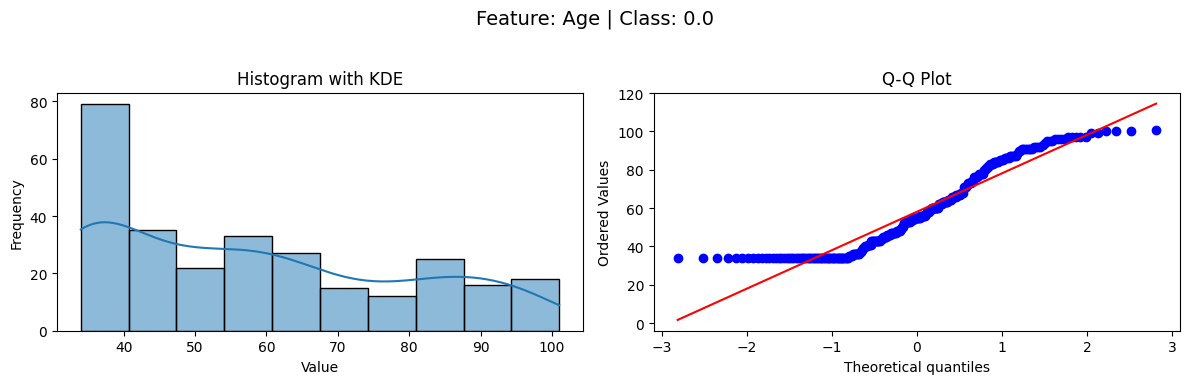

  Class: 1.0 | KS Statistic: 0.1050, p-value: 0.0885
    The feature Age is likely Gaussian.


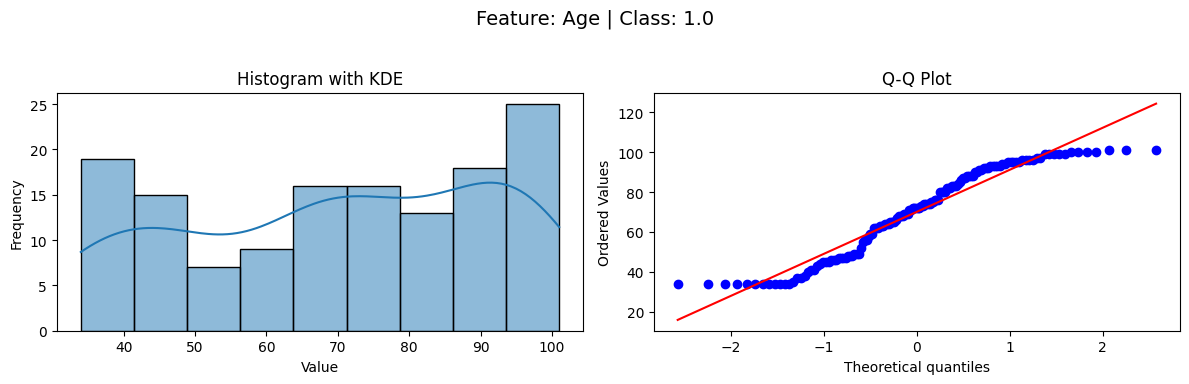

Checking if MonthlySalary is Gaussian...
  Class: 0.0 | KS Statistic: 0.0834, p-value: 0.0372
    The feature MonthlySalary is not Gaussian.


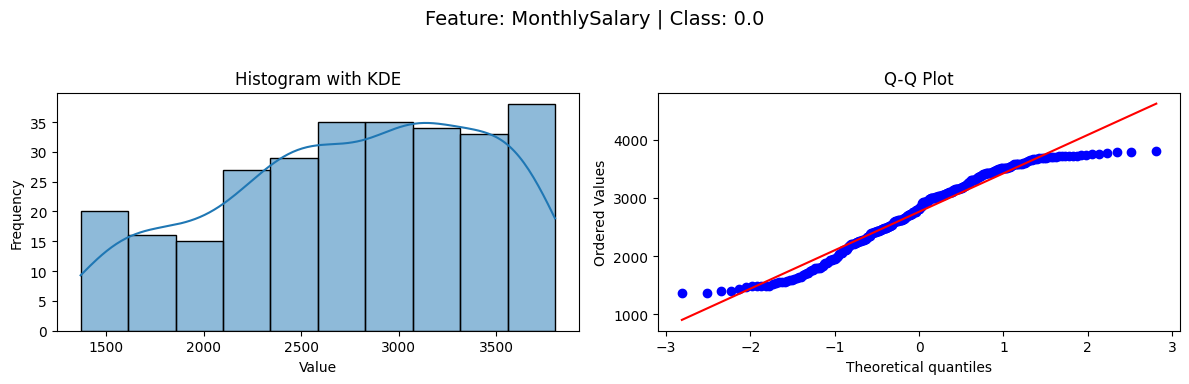

  Class: 1.0 | KS Statistic: 0.0826, p-value: 0.2865
    The feature MonthlySalary is likely Gaussian.


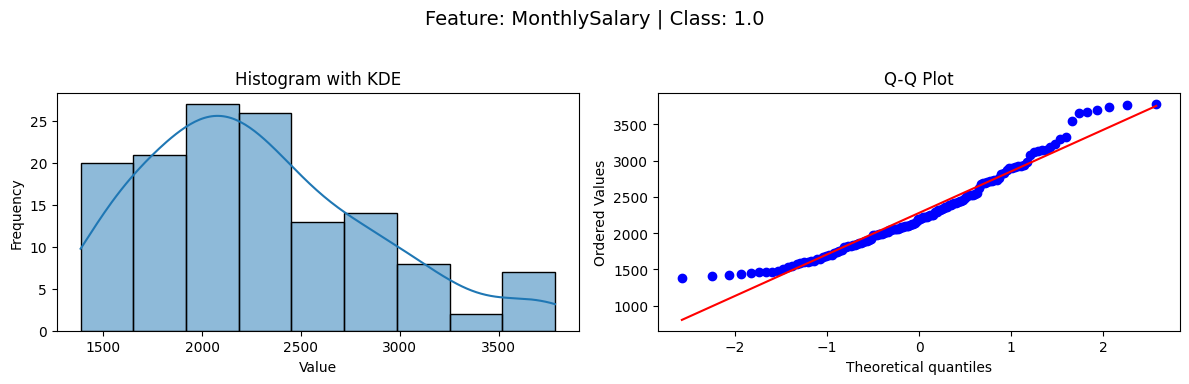

Only 2 out of 4 continuous features are Gaussian.


In [122]:
# Function to check if each continuous feature follows a Gaussian distribution for each class
def check_if_gaussian(continuous_features, X, y):
    size = len(continuous_features) * y.nunique()  # Get the number of continuous features multiplied by the number of unique decisions in y
    n_gaussian = 0  # Initialize a counter for Gaussian features

    # Loop through each continuous feature
    for feature in continuous_features:
        print(f"Checking if {feature} is Gaussian...")

        # Loop through each unique decision in y
        for decision in y.unique():
            subset = X[y == decision][feature]  # Filter the DataFrame for the current decision

            # Check if there are enough samples to perform the test
            if len(subset) < 5:
                print(f"  Class: {decision} | Not enough data to test.")
                continue

            mean = subset.mean()  # Calculate the mean of the subset
            std = subset.std()  # Calculate the standard deviation of the subset
            standardized_data = (subset - mean) / std  # Standardize the data. Mean = 0, Std = 1

            stat, p_value = kstest(standardized_data, 'norm')  # Perform the Kolmogorov-Smirnov test

            # Print the results of the test
            print(f"  Class: {decision} | KS Statistic: {stat:.4f}, p-value: {p_value:.4f}")
            if p_value > 0.05:
                print(f"    The feature {feature} is likely Gaussian.")
                n_gaussian += 1
            else:
                print(f"    The feature {feature} is not Gaussian.")

            # Visualization: Histogram and Q–Q plot
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f"Feature: {feature} | Class: {decision}", fontsize=14)

            # Plot histogram with kernel density estimate (KDE) - helps visualize the distribution
            sns.histplot(subset, kde=True, ax=axes[0])
            axes[0].set_title("Histogram with KDE")
            axes[0].set_xlabel("Value")
            axes[0].set_ylabel("Frequency")

            # Q–Q plot - compares the quantiles of the data against a normal distribution
            # If the points lie on the line, the data is normally distributed
            probplot(subset, dist="norm", plot=axes[1])
            axes[1].set_title("Q-Q Plot")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

    if n_gaussian == size:
        return True
    else:
        print(f"Only {n_gaussian} out of {size} continuous features are Gaussian.")
        return False

gaussian = check_if_gaussian(continuous_features, X_train, y_train)

## Mean and Standard Deviation for Continuous Features

The function `mean_std_continuous` calculates the **mean** and **standard deviation** of each continuous feature, separately for every class in the target variable `y_train`.

**Purpose:** This is useful for models that assume features follow a **Gaussian distribution** per class (e.g., Gaussian Naive Bayes), where the likelihood is computed using these statistics.

In [123]:
# Function to compute the mean and standard deviation of continuous features for each class
def mean_std_continuous(X, y):
    mean_std = {}  # Initialize an empty dictionary to store probabilities

    # Loop through each continuous feature
    for feature in continuous_features:
        mean_std[feature] = {}  # Initialize a dictionary for each continuous feature

        # Loop through each unique decision in y
        for decision in y.unique():
            subset = X[y == decision][feature]  # Filter the DataFrame for the current decision
            mean = subset.mean()  # Calculate the mean of the feature for the current decision
            std = subset.std()  # Calculate the standard deviation of the feature for the current decision

            # Store the mean and standard deviation in the dictionary
            mean_std[feature][decision] = (mean, std)

    return mean_std

print('Mean and standard deviation for continuous features:')
mean_std = mean_std_continuous(X_train, y_train)
for feature, decisions in mean_std.items():
    print(f"  Feature: {feature}")
    for decision, (mean, variance) in decisions.items():
        print(f"    Decision: {decision}, Mean: {mean:.4f}, Variance: {variance:.4f}")
    print()

Mean and standard deviation for continuous features:
  Feature: Age
    Decision: 0.0, Mean: 58.0993, Variance: 20.8981
    Decision: 1.0, Mean: 70.1232, Variance: 21.5130

  Feature: MonthlySalary
    Decision: 0.0, Mean: 2763.2344, Variance: 669.6549
    Decision: 1.0, Mean: 2279.5887, Variance: 578.4760



## Conditional Probability Estimation for Continuous Features

To compute the conditional probabilities of continuous features, we will explore the following methods:

- **Gaussian PDF**
- **Discretization**  
- **Gaussian Mixture Models (GMM)**  
- **Kernel Density Estimation (KDE)**
---

### Normal Probability Density Function (Gaussian PDF)  
The normal probability density function assumes that continuous features follow a Gaussian distribution characterized by a mean (`μ`) and standard deviation (`σ`). It calculates the likelihood of observing a specific value based on this distribution. This method is simple and computationally efficient but relies on the assumption that the data is approximately normally distributed.

Mathematically, it is defined as:

$$
P(x \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{ -\frac{(x - \mu)^2}{2\sigma^2} }
$$

In [124]:
# Function to calculate the conditional probabilities of continuous features
# given a data instance, using the normal distribution
# This function assumes that the continuous features follow a Gaussian distribution
def conditional_probabilities_continuous_gaussian(mean_std, X, y, instance):
    probabilities = {}  # Initialize an empty dictionary to store probabilities

    # Loop through each continuous feature
    for feature in continuous_features:
        probabilities[feature] = {}  # Initialize a dictionary for each continuous feature

        # Loop through each unique decision in y
        for decision in y.unique():
            mean, std = mean_std[feature][decision]  # Get the mean and standard deviation for the feature and decision
            value = instance[feature]  # Get the value of the feature for the instance

            prob = norm.pdf(value, loc=mean, scale=std)  # Calculate the probability using the normal PDF

            probabilities[feature][decision] = prob  # Store the probability in the dictionary

    return probabilities

# Function to calculate the likelihood for a given instance based on continuous feature probabilities
def likelihood_continuous_gaussian(probabilities, X, y):
    likelihoods = {}  # Initialize a dictionary to store likelihoods for each class

    # Iterate over each unique decision in y to calculate likelihoods
    for decision in y.unique():
        likelihoods[decision] = 1  # Start with a likelihood of 1 for each decision

        # For each continuous feature, multiply the likelihood by the conditional probability
        for feature in continuous_features:
            prob = probabilities[feature][decision]
            likelihoods[decision] *= prob  # Multiply by the conditional probability for this feature and decision
    
    return likelihoods

### Discretization  
Discretization involves transforming continuous variables into categorical bins (e.g., intervals or quantiles). This allows us to estimate probabilities using simple frequency counts. While easy to implement, this approach may lead to **loss of information** and depends heavily on how the bins are defined.

In [125]:
def discretize_continuous_features(X, continuous_features, bins=10):
    X_discretized = X.copy()
    bin_info = {}  # To store bin intervals for each feature
    
    for feature in continuous_features:
        # Discretize and return the bins used
        X_discretized[feature], bins_used = pd.cut(
            X[feature], 
            bins=bins, 
            labels=False,
            retbins=True
        )
        bin_info[feature] = bins_used
    
    return X_discretized, bin_info

# Discretize continuous features and get bin intervals
X_discretized, bin_intervals = discretize_continuous_features(X, continuous_features)

# Split the discretized data into training and test sets
X_train_discretized, X_test_discretized, y_train_discretized, y_test_discretized = train_test_split(X_discretized, y, test_size=0.3, random_state=42)

print('Bin intervals for each feature:')
for feature, intervals in bin_intervals.items():
    print(f'Feature: {feature}')
    for i in range(len(intervals)-1):
        print(f'  Bin {i}: [{intervals[i]:.2f}, {intervals[i+1]:.2f})')
    print()

Bin intervals for each feature:
Feature: Age
  Bin 0: [33.93, 40.70)
  Bin 1: [40.70, 47.40)
  Bin 2: [47.40, 54.10)
  Bin 3: [54.10, 60.80)
  Bin 4: [60.80, 67.50)
  Bin 5: [67.50, 74.20)
  Bin 6: [74.20, 80.90)
  Bin 7: [80.90, 87.60)
  Bin 8: [87.60, 94.30)
  Bin 9: [94.30, 101.00)

Feature: MonthlySalary
  Bin 0: [1367.57, 1613.00)
  Bin 1: [1613.00, 1856.00)
  Bin 2: [1856.00, 2099.00)
  Bin 3: [2099.00, 2342.00)
  Bin 4: [2342.00, 2585.00)
  Bin 5: [2585.00, 2828.00)
  Bin 6: [2828.00, 3071.00)
  Bin 7: [3071.00, 3314.00)
  Bin 8: [3314.00, 3557.00)
  Bin 9: [3557.00, 3800.00)



In [ ]:
def discretize_instance(instance, continuous_features, bin_intervals):
    instance_discretized = instance.copy()  # Create a copy of the instance to avoid modifying the original
    
    # Loop through each continuous feature and find the corresponding bin index
    for feature in continuous_features:
        value = instance[feature]  # Get the value of the feature for the instance
        bins = bin_intervals[feature]  # Get the bin intervals for the feature
        
        # Find the bin index for the value
        bin_index = None
        for i in range(len(bins) - 1):
            if bins[i] <= value < bins[i + 1]:
                bin_index = i
                break
        
        # If the value is equal to the last bin edge, assign it to the second last bin
        if bin_index is None:
            if value == bins[-1]:  # Check if the value is equal to the last bin edge
                bin_index = len(bins) - 2  # Assign to the second last bin
            else:
                bin_index = -1  # Assign -1 if the value is outside the bin range
        
        instance_discretized[feature] = bin_index  # Update the feature value to the bin index
    
    return instance_discretized


### Gaussian Mixture Models (GMM)  
GMMs model the probability distribution as a combination of multiple Gaussian components. This makes them ideal for approximating **non-Gaussian or multimodal distributions**. They estimate the **likelihood** of a value more accurately than a single Gaussian in complex cases, which improves classification performance when used in probabilistic classifiers.

In [126]:
# FAZER A FUNÇÃO USANDO GMM

### Kernel Density Estimation (KDE)  
KDE is a non-parametric way to estimate the probability density function of a random variable. It does not assume any specific distribution, making it flexible for modeling complex or unknown distributions. However, KDE can be computationally expensive and sensitive to bandwidth selection.

In [127]:
# FAZER A FUNÇÃO USANDO KDE

In [128]:
instances = X_test.to_dict(orient='records')

def posterior(instance, prior_prob, X, y, discrete_features, continuous_features, gaussian=True, cont=None):
    if gaussian:
        print("Using Gaussian distribution for continuous features.")

        # Compute likelihoods for the discrete features of the instance, 
        # using precomputed conditional probabilities (P(feature=value | class))
        prob_discrete = conditional_probabilities_discrete(X, y, discrete_features)

        likelihoods_discrete = likelihood_discrete(prob_discrete, X, y, instance)

        print('Likelihoods for discrete features:')
        for decision, prob in likelihoods_discrete.items():
            print(f'  P(Decision={decision} | Instance) = {prob}')
        print()

        # Compute conditional probabilities for the continuous features
        # using the Gaussian probability density function
        prob_continuous = conditional_probabilities_continuous_gaussian(mean_std, X, y, instance)

        # Calculate the likelihood for the continuous features of the instance
        likelihoods_continuous = likelihood_continuous_gaussian(prob_continuous, X, y)

        print('Likelihoods for continuous features:')
        for decision, prob in likelihoods_continuous.items():
            print(f'  P(Decision={decision} | Instance) = {prob}')
        print()

        # Combine the likelihoods from discrete and continuous features
        combined_likelihoods = {}
        for decision in y.unique():
            combined_likelihoods[decision] = likelihoods_discrete[decision] * likelihoods_continuous[decision]
        
        print('Combined likelihoods for the instance:')
        for decision, prob in combined_likelihoods.items():
            print(f'  P(Decision={decision} | Instance) = {prob}')
        print()

        # Multiply the combined likelihoods by the prior probabilities to get the posterior probabilities
        posterior_probabilities = {}
        for decision in y.unique():
            posterior_probabilities[decision] = combined_likelihoods[decision] * prior_prob[decision]

        print('Posterior probabilities for the instance:')
        for decision, prob in posterior_probabilities.items():
            print(f'  P(Decision={decision} | Instance) = {prob}')
        print()

        # Determine the class with the highest posterior probability
        predicted_class = max(posterior_probabilities, key=posterior_probabilities.get)
        print(f'Predicted class for the instance: {predicted_class}')

    else:
        print("Using non-Gaussian distribution for continuous features.")
        if cont == 'D':
            pass

        elif cont == 'GMM':
            # Implement GMM logic here
            pass
        
        elif cont == 'KDE':
            # Implement KDE logic here
            pass

    return predicted_class

predicted = []
for instance in instances:
    predicted_class = posterior(instance, prior_prob, X_train, y_train, discrete_features, continuous_features)
    predicted.append(predicted_class)
    print('-' * 50)

Using Gaussian distribution for continuous features.
Likelihoods for discrete features:
  P(Decision=0.0 | Instance) = 0.010268421754912061
  P(Decision=1.0 | Instance) = 0.01199285424297464

Likelihoods for continuous features:
  P(Decision=0.0 | Instance) = 8.053026718855848e-07
  P(Decision=1.0 | Instance) = 4.328197761037291e-06

Combined likelihoods for the instance:
  P(Decision=0.0 | Instance) = 8.26918747527875e-09
  P(Decision=1.0 | Instance) = 5.1907444882889406e-08

Posterior probabilities for the instance:
  P(Decision=0.0 | Instance) = 5.5521687334014455e-09
  P(Decision=1.0 | Instance) = 1.705530331866366e-08

Predicted class for the instance: 1.0
--------------------------------------------------
Using Gaussian distribution for continuous features.
Likelihoods for discrete features:
  P(Decision=0.0 | Instance) = 0.05047756944854056
  P(Decision=1.0 | Instance) = 0.0052241599922048625

Likelihoods for continuous features:
  P(Decision=0.0 | Instance) = 4.073819484948129e

In [129]:
# Compute accuracy
def compute_accuracy(predicted, y):
    correct_predictions = sum(1 for p, t in zip(predicted, y) if p == t)
    accuracy = correct_predictions / len(y) * 100
    return accuracy

print(f'Accuracy of the model: {compute_accuracy(predicted, y_test):.2f}%')

Accuracy of the model: 81.67%


In [130]:
# TODO
# fazer multiplicação das probabilidades continuas
# multiplicar com as discretas
# e multiplicar com a probabilidade a priori
# laplace smoothing for discrete features 